# Mean daily source water dynamics

In [2]:
import xarray as xr
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
def wm_day_divide(mydata):
    # organize ariane results into daily volume contribution from each water mass 
    start = 2401
    length =int((np.max(mydata.init_t)-start+1)/24)

    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    fresh = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    cuc = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    south = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    north = [np.sum(mydata.final_transp[(mydata.final_section==bdy_nor) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_d = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth > 120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_s = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth <=120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    
    loop = [np.sum(mydata.final_transp[(mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
 
    return fresh, cuc, south, north, offshore_d, offshore_s, loop

def transport_df(data, start, length, years):
    # Create a master dataFrame to hold all the transport data, sorted by year day
    # data = list of transport arrays (from wm_day_divide) 
    # start = list of dt.datetime start days (start of season, not start of ariane run)
    # length = list of interger season length

    transport_data = pd.DataFrame()

    # Loop through each year's data and add it to the master dataFrame
    for year, start, season_length, transport in zip(years, startday, length, data):
        # Generate dates for the season
        dates = [start + dt.timedelta(days=x) for x in range(season_length)]
        
        # Extract yearday
        yearday = [date.timetuple().tm_yday for date in dates]
        
        # Create a temporary dataFrame
        temp_df = pd.DataFrame({
            'yearday': yearday,
            f'transport_{year}': transport  # Transport column named by year
        })
        
        # Merge with the master dataFrame on 'month', 'day', and 'yearday'
        if transport_data.empty:
            transport_data = temp_df
        else:
            transport_data = pd.merge(transport_data, temp_df, on=['yearday'], how='outer')

        # Sort by yearday for better organization
        transport_data = transport_data.sort_values(by=['yearday']).reset_index(drop=True)

    return transport_data

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
window = 4

# proprotion of tidally pumped parcels
def pumped(winter,spring,summer,fall):
    
    pump = np.sum([np.sum(winter.final_transp[(winter.final_section==0) & (abs(winter.init_t-winter.final_t) <= 24)]),
                    np.sum(spring.final_transp[(spring.final_section==0) & (abs(spring.init_t-spring.final_t) <= 24)]),
                    np.sum(summer.final_transp[(summer.final_section==0) & (abs(summer.init_t-summer.final_t) <= 24)]),
                    np.sum(fall.final_transp[(fall.final_section==0) & (abs(fall.init_t-fall.final_t) <= 24)])])
    tot = np.sum(winter.final_transp) + np.sum(spring.final_transp) + np.sum(summer.final_transp) + np.sum(fall.final_transp)
    prop = pump/tot

    return prop.values*100

## Upwelling

In [4]:
df23 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20230922/ariane_positions_quantitative.nc')
df22 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20221015/ariane_positions_quantitative.nc')
df21 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20210922/ariane_positions_quantitative.nc')
df20 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20201017/ariane_positions_quantitative.nc')
df19 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20191105/ariane_positions_quantitative.nc')
df18 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20180906/ariane_positions_quantitative.nc')
df17 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20171012/ariane_positions_quantitative.nc')
df16 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20160913/ariane_positions_quantitative.nc')
df15 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20150905/ariane_positions_quantitative.nc')
df14 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20140903/ariane_positions_quantitative.nc')

In [5]:
fresh23, cuc23, south23, north23, offshore_d23, offshore_s23, loop23 = wm_day_divide(df23)
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(df22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(df21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(df20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(df19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(df18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(df17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(df16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(df15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(df14)


In [6]:
endday = [dt.datetime(2014, 9, 3), 
            dt.datetime(2015, 9, 5), dt.datetime(2016, 9, 13), 
            dt.datetime(2017, 10, 12), dt.datetime(2018, 9, 6), 
             dt.datetime(2019, 11, 5), dt.datetime(2020, 10, 17),
            dt.datetime(2021, 9, 22), dt.datetime(2022, 10, 15),
            dt.datetime(2023,9,22)]  # Start dates dt.datetime(2013, 10, 24), 
length = [161, 144, 158, 156,128,193,244,189, 117,136]  # Number of days in the season for each year #219
startday = [endday[i]-dt.timedelta(days=length[i]) for i in range(len(endday))]  # Start dates

In [7]:
Ufresh = transport_df([fresh14, fresh15, fresh16, fresh17, fresh18, fresh19, fresh20,fresh21,fresh22,fresh23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Usouth = transport_df([south14, south15, south16, south17, south18, south19, south20,south21,south22,south23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Unorth = transport_df([north14, north15, north16, north17, north18, north19, north20,north21,north22,north23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Ucuc = transport_df([cuc14, cuc15, cuc16, cuc17, cuc18, cuc19, cuc20,cuc21,cuc22,cuc23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Uoffshore_d = transport_df([offshore_d14, offshore_d15, offshore_d16, offshore_d17, offshore_d18, offshore_d19, offshore_d20,offshore_d21,offshore_d22,offshore_d23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Uoffshore_s = transport_df([offshore_s14, offshore_s15, offshore_s16, offshore_s17, offshore_s18, offshore_s19, offshore_s20,offshore_s21,offshore_s22,offshore_s23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Uloop = transport_df([loop14, loop15, loop16, loop17, loop18, loop19, loop20,loop21,loop22,loop23], startday, length,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])

In [8]:
# number of similations overallaping in a julianne day
jsta = [date.timetuple().tm_yday for date in startday]
jend =[date.timetuple().tm_yday for date in endday]

UPcounts = np.zeros(np.max(jend)-np.min(jsta)+1)
jul = (np.arange(np.min(jsta),np.max(jend)+1))

for i in range(len(UPcounts)):
    for j in range(len(jsta)):
        if jul[i] >= jsta[j] and jul[i] <= jend[j]:
            UPcounts[i]+=1

## Downwelling

In [9]:
df22 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20230419/ariane_positions_quantitative.nc')
df21 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20220125/ariane_positions_quantitative.nc')
df20 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20210202/ariane_positions_quantitative.nc')
df19 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20200127/ariane_positions_quantitative.nc')
df18 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20190406/ariane_positions_quantitative.nc')
df17 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20180201/ariane_positions_quantitative.nc')
df16 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20170419/ariane_positions_quantitative.nc')
df15 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20160319/ariane_positions_quantitative.nc')
df14 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20150212/ariane_positions_quantitative.nc')
df13 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/down_cas7/S_T/20140306/ariane_positions_quantitative.nc')


In [10]:
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(df22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(df21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(df20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(df19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(df18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(df17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(df16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(df15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(df14)
fresh13, cuc13, south13, north13, offshore_d13, offshore_s13, loop13 = wm_day_divide(df13)

In [11]:
endday = [dt.datetime(2014, 3, 6), dt.datetime(2015, 2, 12), dt.datetime(2016, 3, 19),dt.datetime(2017, 4, 19), dt.datetime(2018, 2, 1),
          dt.datetime(2019, 4, 6), dt.datetime(2020, 1, 27),dt.datetime(2021, 2, 2), dt.datetime(2022, 1, 25),dt.datetime(2023,4,19)] 
length = [113, 143, 149, 198, 91, 163, 53, 82, 105,176]  # Number of days in the season for each year
startday = [endday[i]-dt.timedelta(days=length[i]) for i in range(len(endday))]  # Start dates

In [12]:
Dfresh = transport_df([fresh13, fresh14,fresh15,fresh16,fresh17,fresh18, fresh19,fresh20,fresh21,fresh22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
Dsouth = transport_df([south13, south14,south15,south16,south17,south18, south19,south20,south21,south22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
Dnorth = transport_df([north13, north14,north15,north16,north17,north18, north19,north20,north21,north22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
Dcuc = transport_df([cuc13,cuc14,cuc15,cuc16,cuc17,cuc18, cuc19,cuc20,cuc21,cuc22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
Doffshore_d = transport_df([offshore_d13, offshore_d14,offshore_d15,offshore_d16,offshore_d17,offshore_d18, offshore_d19,offshore_d20,offshore_d21,offshore_d22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
Doffshore_s = transport_df([offshore_s13, offshore_s14,offshore_s15,offshore_s16,offshore_s17,offshore_s18, offshore_s19,offshore_s20,offshore_s21,offshore_s22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])
Dloop = transport_df([loop13,loop14,loop15,loop16,loop17,loop18, loop19,loop20,loop21,loop22], startday, length,[2013,2014, 2015,2016,2017,2018,2019,2020,2021,2022])

In [13]:
# number of similations overallaping in a julianne day
jsta = [date.timetuple().tm_yday for date in startday]
jend =[date.timetuple().tm_yday + 365 for date in endday]

DWcounts = np.zeros(np.max(jend)-np.min(jsta)+1)
jul = (np.arange(np.min(jsta),np.max(jend)+1))

for i in range(len(DWcounts)):
    for j in range(len(jsta)):
        if jul[i] >= jsta[j] and jul[i] <= jend[j]:
            DWcounts[i]+=1

# Full year

In [14]:
# get days of upweling and downwelling in the context of the full year

years = np.arange(2014,2023+1,1)
Dmin, Dmax = 265,108 # split at index = 365-265-1=99 to 100
Umin, Umax = 47,309

d = {'count':DWcounts,'jday':np.zeros(len(DWcounts))}
DWcount = pd.DataFrame(d)

j=0
for ind in DWcount.index:
    if ind >= 101:
        DWcount.jday[j]=ind-101+1
    else:
        DWcount.jday[j]=ind+265
    j+=1
DWcount = DWcount.sort_values(by=['jday'])

d = {'count':UPcounts,'jday':np.zeros(len(UPcounts))}
UPcount = pd.DataFrame(d)
UPcount.jday = UPcount.index+Umin

In [15]:
# bring in transition periods
f14 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20140921/ariane_positions_quantitative.nc")
f15 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20151021/ariane_positions_quantitative.nc")
f16 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20161002/ariane_positions_quantitative.nc")
f17 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20171101/ariane_positions_quantitative.nc")
f18 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20181024/ariane_positions_quantitative.nc")
f19 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20191204/ariane_positions_quantitative.nc")
f20 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20201111/ariane_positions_quantitative.nc")
f21 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20211006/ariane_positions_quantitative.nc")
f22 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20221024/ariane_positions_quantitative.nc")
f23 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/fall_cas7/S_T/20231013/ariane_positions_quantitative.nc")
flen = [18,45,19,20,48,28,25,21,20,20]
fend = np.array([dt.datetime(2014,9,21),dt.datetime(2015,10,21),dt.datetime(2016,10,2),dt.datetime(2017,11,1),dt.datetime(2018,10,24),
                 dt.datetime(2019,12,4),dt.datetime(2020,11,11),dt.datetime(2021,10,6),dt.datetime(2022,10,24),dt.datetime(2023,10,13)])
fstart = [fend[i]-dt.timedelta(days=flen[i]) for i in range(len(fend))]  # Start dates

s14 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20140325/ariane_positions_quantitative.nc")
s15 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20150413/ariane_positions_quantitative.nc")
s16 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20160407/ariane_positions_quantitative.nc")
s17 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20170508/ariane_positions_quantitative.nc")
s18 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20180430/ariane_positions_quantitative.nc")
s19 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20190425/ariane_positions_quantitative.nc")
s20 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20200215/ariane_positions_quantitative.nc")
s21 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20210318/ariane_positions_quantitative.nc")
s22 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20220611/ariane_positions_quantitative.nc")
s23 = xr.open_dataset("/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/spring_cas7/S_T/20230508/ariane_positions_quantitative.nc")
slen = [18,60,19,19,88,19,19,42,137,19]
send = np.array([dt.datetime(2014,3,25),dt.datetime(2015,4,13),dt.datetime(2016,4,7),dt.datetime(2017,5,8),dt.datetime(2018,4,30),
                 dt.datetime(2019,4,25),dt.datetime(2020,2,15),dt.datetime(2021,3,18),dt.datetime(2022,6,11),dt.datetime(2023,5,8)])
sstart = [send[i]-dt.timedelta(days=slen[i]) for i in range(len(send))]  # Start dates


In [16]:
fresh23, cuc23, south23, north23, offshore_d23, offshore_s23, loop23 = wm_day_divide(f23)
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(f22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(f21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(f20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(f19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(f18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(f17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(f16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(f15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(f14)

Ffresh = transport_df([fresh14, fresh15, fresh16, fresh17, fresh18, fresh19, fresh20,fresh21,fresh22,fresh23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Fsouth = transport_df([south14, south15, south16, south17, south18, south19, south20,south21,south22,south23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Fnorth = transport_df([north14, north15, north16, north17, north18, north19, north20,north21,north22,north23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Fcuc = transport_df([cuc14, cuc15, cuc16, cuc17, cuc18, cuc19, cuc20,cuc21,cuc22,cuc23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Foffshore_d = transport_df([offshore_d14, offshore_d15, offshore_d16, offshore_d17, offshore_d18, offshore_d19, offshore_d20,offshore_d21,offshore_d22,offshore_d23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Foffshore_s = transport_df([offshore_s14, offshore_s15, offshore_s16, offshore_s17, offshore_s18, offshore_s19, offshore_s20,offshore_s21,offshore_s22,offshore_s23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Floop = transport_df([loop14, loop15, loop16, loop17, loop18, loop19, loop20,loop21,loop22,loop23], fstart, flen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])

In [17]:
fresh23, cuc23, south23, north23, offshore_d23, offshore_s23, loop23 = wm_day_divide(s23)
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(s22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(s21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(s20)
fresh19, cuc19, south19, north19, offshore_d19, offshore_s19, loop19 = wm_day_divide(s19)
fresh18, cuc18, south18, north18, offshore_d18, offshore_s18, loop18 = wm_day_divide(s18)
fresh17, cuc17, south17, north17, offshore_d17, offshore_s17, loop17 = wm_day_divide(s17)
fresh16, cuc16, south16, north16, offshore_d16, offshore_s16, loop16 = wm_day_divide(s16)
fresh15, cuc15, south15, north15, offshore_d15, offshore_s15, loop15 = wm_day_divide(s15)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(s14)

Sfresh = transport_df([fresh14, fresh15, fresh16, fresh17, fresh18, fresh19, fresh20,fresh21,fresh22,fresh23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Ssouth = transport_df([south14, south15, south16, south17, south18, south19, south20,south21,south22,south23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Snorth = transport_df([north14, north15, north16, north17, north18, north19, north20,north21,north22,north23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Scuc = transport_df([cuc14, cuc15, cuc16, cuc17, cuc18, cuc19, cuc20,cuc21,cuc22,cuc23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Soffshore_d = transport_df([offshore_d14, offshore_d15, offshore_d16, offshore_d17, offshore_d18, offshore_d19, offshore_d20,offshore_d21,offshore_d22,offshore_d23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Soffshore_s = transport_df([offshore_s14, offshore_s15, offshore_s16, offshore_s17, offshore_s18, offshore_s19, offshore_s20,offshore_s21,offshore_s22,offshore_s23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
Sloop = transport_df([loop14, loop15, loop16, loop17, loop18, loop19, loop20,loop21,loop22,loop23], sstart, slen,[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])

In [18]:
# rename downwelling columns so that everything can be combined

Dfresh.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

Dsouth.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

Dnorth.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

Dcuc.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

Doffshore_d.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

Doffshore_s.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

Dloop.rename(columns={'transport_2013':'transport_2014', 'transport_2014':'transport_2015', 'transport_2015':'transport_2016',
       'transport_2016':'transport_2017', 'transport_2017':'transport_2018', 'transport_2018':'transport_2019', 'transport_2019':'transport_2020',
       'transport_2020':'transport_2021', 'transport_2021':'transport_2022', 'transport_2022':'transport_2023'}, inplace=True)

In [19]:
# Combine

# fresh
concat = pd.concat([Ufresh,Dfresh,Ffresh,Sfresh])
fresh = concat.groupby(concat['yearday']).max()
mean = [np.mean(fresh.loc[i+1,:]) for i in range(len(fresh))]
quart25 = [fresh.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(fresh))]
quart75 = [fresh.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(fresh))]
fresh['mean'] = mean
fresh['quart25'] = quart25
fresh['quart75'] = quart75

# south
concat = pd.concat([Usouth,Dsouth,Fsouth,Ssouth])
south = concat.groupby(concat['yearday']).max()
mean = [np.mean(south.loc[i+1,:]) for i in range(len(south))]
quart25 = [south.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(south))]
quart75 = [south.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(south))]
south['mean'] = mean
south['quart25'] = quart25
south['quart75'] = quart75

# cuc
concat = pd.concat([Ucuc,Dcuc,Fcuc,Scuc])
cuc = concat.groupby(concat['yearday']).max()
mean = [np.mean(cuc.loc[i+1,:]) for i in range(len(cuc))]
quart25 = [cuc.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(cuc))]
quart75 = [cuc.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(cuc))]
cuc['mean'] = mean
cuc['quart25'] = quart25
cuc['quart75'] = quart75

# north
concat = pd.concat([Unorth,Dnorth,Fnorth,Snorth])
north = concat.groupby(concat['yearday']).max()
mean = [np.mean(north.loc[i+1,:]) for i in range(len(north))]
quart25 = [north.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(north))]
quart75 = [north.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(north))]
north['mean'] = mean
north['quart25'] = quart25
north['quart75'] = quart75

# offshore_s
concat = pd.concat([Uoffshore_s,Doffshore_s,Foffshore_s,Soffshore_s])
offs = concat.groupby(concat['yearday']).max()
mean = [np.mean(offs.loc[i+1,:]) for i in range(len(offs))]
quart25 = [offs.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(offs))]
quart75 = [offs.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(offs))]
offs['mean'] = mean
offs['quart25'] = quart25
offs['quart75'] = quart75

# offshore_d
concat = pd.concat([Uoffshore_d,Doffshore_d,Foffshore_d,Soffshore_d])
offd = concat.groupby(concat['yearday']).max()
mean = [np.mean(offd.loc[i+1,:]) for i in range(len(offd))]
quart25 = [offd.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(offd))]
quart75 = [offd.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(offd))]
offd['mean'] = mean
offd['quart25'] = quart25
offd['quart75'] = quart75

# Loop
concat = pd.concat([Uloop,Dloop,Floop,Sloop])
loop = concat.groupby(concat['yearday']).max()
mean = [np.mean(loop.loc[i+1,:]) for i in range(len(loop))]
quart25 = [loop.loc[i+1,:].agg(lambda x: x.quantile(0.25)) for i in range(len(loop))]
quart75 = [loop.loc[i+1,:].agg(lambda x: x.quantile(0.75)) for i in range(len(loop))]
loop['mean'] = mean
loop['quart25'] = quart25
loop['quart75'] = quart75


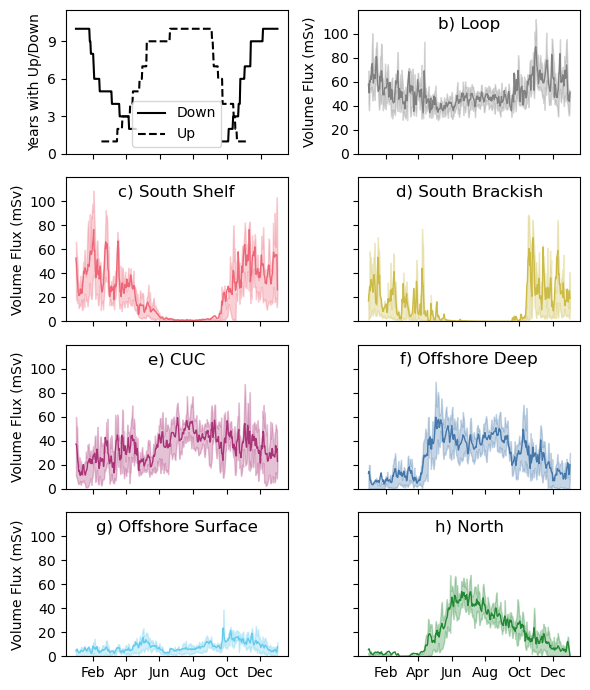

In [20]:
# plot data mean with range using quartiles
ymax=120000

fig, ax = plt.subplots(4,2, figsize=(6,7))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','20','40','60','80','100'])
    axs.set_ylabel('Volume Flux (mSv)')
for axs in [ax[1,1],ax[2,1],ax[3,1]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels([])

for i in range(4):
    for axs in ax[i]:
        axs.set_xticks([397-365,456-365,152,213,274,335]) #february 1, april 1, october 1, december 1
ax[3,0].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])
ax[3,1].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])


# count of the number of summers and winters with this date in the range
split=109
ax[0,0].plot(DWcount.jday[:split],DWcount['count'][:split],'k',label='Down')
ax[0,0].plot(DWcount.jday[split:],DWcount['count'][split:],'k')
ax[0,0].plot(UPcount.jday,UPcount['count'],'k--',label='Up')
ax[0,0].set_ylim([0,11.5])
ax[0,0].set_yticks([0,3,6,9])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel("Years with Up/Down")
ax[0,0].legend()

# loop flow
ax[0,1].plot(loop.index.values,loop['mean'],'grey',lw=1)
ax[0,1].fill_between(loop.index.values,
                        loop.quart25,
                        loop.quart75,
                        color='grey',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('b) Loop',y=1,pad=-14)

# south shelf flow
ax[1,0].plot(south.index.values,south['mean'],'#EE6677',lw=1)
ax[1,0].fill_between(south.index.values,
                        south.quart25,
                        south.quart75,
                        color='#EE6677',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('c) South Shelf',y=1,pad=-14)


# fresh flow
ax[1,1].plot(fresh.index.values,fresh['mean'],'#CCBB44',lw=1)
ax[1,1].fill_between(fresh.index.values,
                        fresh.quart25,
                        fresh.quart75,
                        color='#CCBB44',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('d) South Brackish',y=1,pad=-14)

# cuc flow
ax[2,0].plot(cuc.index.values,cuc['mean'],'#AA3377',lw=1)
ax[2,0].fill_between(cuc.index.values,
                        cuc.quart25,
                        cuc.quart75,
                        color='#AA3377',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('e) CUC',y=1,pad=-14)

# offshore deep flow
ax[2,1].plot(offd.index.values,offd['mean'],'#4477AA',lw=1)
ax[2,1].fill_between(offd.index.values,
                        offd.quart25,
                        offd.quart75,
                        color='#4477AA',alpha=0.3)
ax[2,1].set_ylim([0,ymax])
ax[2,1].set_title('f) Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])

# offshore surface flow
ax[3,0].plot(offs.index.values,offs['mean'],'#66CCEE',lw=1)
ax[3,0].fill_between(offs.index.values,
                        offs.quart25,
                        offs.quart75,
                        color='#66CCEE',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('g) Offshore Surface',y=1,pad=-14)


# north flow
ax[3,1].plot(north.index.values,north['mean'],'#228833',lw=1)
ax[3,1].fill_between(north.index.values,
                        north.quart25,
                        north.quart75,
                        color='#228833',alpha=0.3)
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('h) North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


# # add letter markers to each figure 
# ax[0,0].text(.03, .05, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=12)



plt.tight_layout()
# plt.savefig('./figures/total_dynamics.pdf')

In [21]:
# total flow
total = loop+offd+offs+north+south+cuc+fresh
col = ['transport_2014','transport_2015','transport_2016','transport_2017','transport_2018','transport_2019','transport_2020','transport_2021','transport_2022','transport_2023']
mean = [np.mean(total.loc[i+1,col]) for i in range(len(total))]
quart25 = [total.loc[i+1,col].agg(lambda x: x.quantile(0.25)) for i in range(len(total))]
quart75 = [total.loc[i+1,col].agg(lambda x: x.quantile(0.75)) for i in range(len(total))]

total['mean'] = mean
total['quart25'] = quart25
total['quart75'] = quart75

In [22]:
total

,transport_2014,transport_2015,transport_2016,transport_2017,transport_2018,transport_2019,transport_2020,transport_2021,transport_2022,transport_2023,mean,quart25,quart75
yearday,,,,,,,,,,,,,
1,102519.114382,233260.520673,146965.635455,269359.939118,213335.004628,225538.181155,100158.364498,155649.094505,291672.044687,145218.839084,188367.673818,145655.538177,231329.935793
2,54086.345227,198020.317934,126770.369582,322822.913172,237487.012930,132342.711621,129401.728177,163271.921355,331631.598175,133737.763358,182957.268153,130136.974038,227620.339181
3,85287.905725,190323.617483,147520.929158,284748.419875,246988.687063,101007.878704,197892.104270,163804.448841,287023.760868,106787.260336,181138.501232,116970.677542,234714.541365
4,132341.002080,150525.708482,137798.381932,220141.981711,175410.870364,140892.643932,133922.958830,140460.520272,222760.337294,106838.418198,156109.282309,134891.814606,169189.579893
5,151725.788794,129539.123124,153244.886327,203404.307126,135432.040899,128532.500646,116533.740411,172100.282143,200140.237965,144512.298860,153516.520629,131012.352568,167386.433189
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,147431.103455,254882.567067,129172.174778,98762.455078,197734.694829,173761.358439,272953.286931,93993.953789,430074.045345,141115.185630,193988.082534,132157.927491,240595.599008
363,134134.253953,347639.827152,161074.652484,115876.316807,216398.176154,105007.911798,223276.904099,91242.811035,362021.876369,125634.095683,188230.682553,118315.761526,221557.222112
364,135956.536392,259623.470341,169117.008665,76836.463810,207169.765100,202639.287864,87986.885180,144198.315486,327826.039561,196290.751148,180764.452355,138016.981166,206037.145791


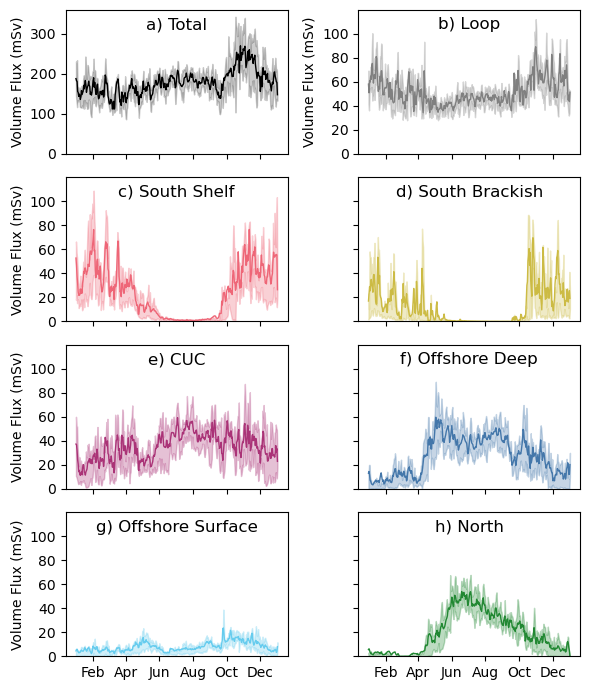

In [23]:
# plot data mean with range using quartiles
ymax=120000

fig, ax = plt.subplots(4,2, figsize=(6,7))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','20','40','60','80','100'])
    axs.set_ylabel('Volume Flux (mSv)')
for axs in [ax[1,1],ax[2,1],ax[3,1]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels([])

ax[0,0].set_yticks([0,100000,200000,300000])
ax[0,0].set_yticklabels(['0','100','200','300'])
ax[0,0].set_ylabel('Volume Flux (mSv)')

for i in range(4):
    for axs in ax[i]:
        axs.set_xticks([397-365,456-365,152,213,274,335]) #february 1, april 1, october 1, december 1
ax[3,0].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])
ax[3,1].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])


# total flow
ax[0,0].plot(total.index.values,total['mean'],'k',lw=1)
ax[0,0].fill_between(total.index.values,
                        total.quart25,
                        total.quart75,
                        color='k',alpha=0.2)
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim([0,360000])
ax[0,0].set_title('a) Total',y=1,pad=-14)

# loop flow
ax[0,1].plot(loop.index.values,loop['mean'],'grey',lw=1)
ax[0,1].fill_between(loop.index.values,
                        loop.quart25,
                        loop.quart75,
                        color='grey',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('b) Loop',y=1,pad=-14)

# south shelf flow
ax[1,0].plot(south.index.values,south['mean'],'#EE6677',lw=1)
ax[1,0].fill_between(south.index.values,
                        south.quart25,
                        south.quart75,
                        color='#EE6677',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('c) South Shelf',y=1,pad=-14)


# fresh flow
ax[1,1].plot(fresh.index.values,fresh['mean'],'#CCBB44',lw=1)
ax[1,1].fill_between(fresh.index.values,
                        fresh.quart25,
                        fresh.quart75,
                        color='#CCBB44',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('d) South Brackish',y=1,pad=-14)

# cuc flow
ax[2,0].plot(cuc.index.values,cuc['mean'],'#AA3377',lw=1)
ax[2,0].fill_between(cuc.index.values,
                        cuc.quart25,
                        cuc.quart75,
                        color='#AA3377',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('e) CUC',y=1,pad=-14)

# offshore deep flow
ax[2,1].plot(offd.index.values,offd['mean'],'#4477AA',lw=1)
ax[2,1].fill_between(offd.index.values,
                        offd.quart25,
                        offd.quart75,
                        color='#4477AA',alpha=0.3)
ax[2,1].set_ylim([0,ymax])
ax[2,1].set_title('f) Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])

# offshore surface flow
ax[3,0].plot(offs.index.values,offs['mean'],'#66CCEE',lw=1)
ax[3,0].fill_between(offs.index.values,
                        offs.quart25,
                        offs.quart75,
                        color='#66CCEE',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('g) Offshore Surface',y=1,pad=-14)


# north flow
ax[3,1].plot(north.index.values,north['mean'],'#228833',lw=1)
ax[3,1].fill_between(north.index.values,
                        north.quart25,
                        north.quart75,
                        color='#228833',alpha=0.3)
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('h) North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


# # add letter markers to each figure 
# ax[0,0].text(.03, .05, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=12)



plt.tight_layout()
plt.savefig('./figures/total_dynamics.pdf')

# proportion tidally pumped

In [ ]:
up23 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20230922/ariane_positions_quantitative.nc')
up22 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20221015/ariane_positions_quantitative.nc')
up21 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20210922/ariane_positions_quantitative.nc')
up20 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20201017/ariane_positions_quantitative.nc')
up19 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20191105/ariane_positions_quantitative.nc')
up18 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20180906/ariane_positions_quantitative.nc')
up17 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20171012/ariane_positions_quantitative.nc')
up16 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20160913/ariane_positions_quantitative.nc')
up15 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20150905/ariane_positions_quantitative.nc')
up14 = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/results/up_cas7/S_T/20140903/ariane_positions_quantitative.nc')

In [ ]:
print(pumped(df13,s14,up14,f14))
print(pumped(df14,s15,up15,f15))
print(pumped(df15,s16,up16,f16))
print(pumped(df16,s17,up17,f17))
print(pumped(df17,s18,up18,f18))
print(pumped(df18,s19,up19,f19))
print(pumped(df19,s20,up20,f20))
print(pumped(df20,s21,up21,f21))
print(pumped(df21,s22,up22,f22))
print(pumped(df22,s23,up23,f23))


72.11644467243651
71.39255676725857
71.7041657725924
72.05753805218689
72.1367637885547
73.26990420866053
72.60199650956207
72.03246305365188
71.66763194427605
73.80733976142533
